# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier, from loading and inspecting the dataset to training a **pre-trained** Convolutional Neural Network architecture. The sections are to guide you but you do not have to follow that specific order.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Rules and Comments
- From the list of datasets and architectures listed in canvas, each student was atributed **1 dataset and 1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description.
- This is an DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course). Remember that you will have to defend the assignment at the end of the semester.
- **Deadline is March 25**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name:**  **Mei Jiaojiao**
**Neptun ID:** **V6FISC**

## Task description
Your task is to train an already pretrained Convolutional Neural Network architecture on a dataset, both given in canvas. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem.

The dataset shoud be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.

# Base setting

In [1]:
# 是否开启事件记录（数据记录），如果开启的话，就会记录数据文件，如果不开启，则不重复记录，第一次加载时可以打开
is_record_events = True
# 批量处理数据，不能太大，GPU内存不够
batch_size_setting = 16
# 查看当前硬件
!nvidia-smi

Fri Mar 25 00:52:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.09       Driver Version: 497.09       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:1C:00.0  On |                  N/A |
|  0%   41C    P8    21W / 240W |   3914MiB /  8192MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import datasets

In [1]:
# 系统操作类
import os
# 文件操作类
import shutil
# 数组操作类
import numpy as np
# 图片读取类
from PIL import Image
# 画图类
import matplotlib.pyplot as plt
# 时间记录类
import time

In [2]:
# 解压类
import tarfile
# 进度条
from tqdm import tqdm

In [3]:
# 导入下载方法
from torchvision.datasets.utils import download_url
# 导入数据集父类
from torch.utils.data import Dataset, DataLoader
# 配合可视化模块SummaryWriter一起用
from torch.utils.tensorboard import SummaryWriter
# 用于转化图片
from torchvision import transforms
# 科学计算基础包
import torch
# 模拟构建Tensor对象，以方便后续查看神经网络结构
from torch import Tensor
# torchvision帮我们构建好的模型
from torchvision import models
# 神经网络相关模块
from torch import nn
# 优化器
import torch.optim as optim
# 自动学习率修正器
from torch.optim import lr_scheduler

In [5]:
def download_and_extract(url, path):
    if os.path.exists("./datasets"):
        print("Dataset has existed, no need download!")
    else:
        # 文件是否损坏标志位
        flag = True
        while flag:
            # download dataset
            print("Start download dataset!")
            download_url(url, '.')
            # extract dataset
            print("Start extracting dataset!")
            try:
                with tarfile.open('./imagenette-320.tgz', 'r:gz') as tar:
                    tar.extractall(path)
                flag = False
            except Exception:
                print("Current file imagenette-320.tgz has broken, now start download new!")
                os.remove("./imagenette-320.tgz")
        print("Finish extracting dataset!")

In [6]:
dataset_path = './datasets'
download_and_extract("https://s3.amazonaws.com/fast-ai-imageclas/imagenette-320.tgz", dataset_path)

Dataset has existed, no need download!


In [7]:
# 抽取数据集类，从当前数据集的根目录寻找对应的子目录进行抽取(定义时需要给定数据集的最外层目录，抽取时需要给定最外层目录下的子目录名称)
class Extracter_Dataset_Imagenette():
    # file_path 数据集的最外层目录
    # factor 抽取因子，如果有十份文件，抽取0.1，则会随机抽取当前10%数据量的10%做成新的文件
    def __init__(self, file_path, factor):
        self.file_path = file_path
        self.factor = factor

    def _mv_file(self, src, dst):
        if not os.path.isfile(src):
            print("%s not exit!" % (src))
        else:
            fpath, fname = os.path.split(dst)
        if not os.path.exists(fpath):
            os.makedirs(fpath)
        shutil.move(src, dst)

    # 随机取文件
    def _random_retrieve(self, li, num):
        arr = np.array(li)
        np.random.shuffle(arr)
        return arr[: num]

    '''
        当前类根目录下
        src 源子目录（必须）
        target 目标子目录（非必须，默认test）
    '''

    def extract(self, src, target='test'):
        target_path = os.path.join(self.file_path, target)
        if os.path.exists(target_path):
            print("Target directory has existed, no need extract new!")
        else:
            print(f"Start extracting data from {src} to {target}!")
            src_path = os.path.join(self.file_path, src)
            dirs = os.listdir(src_path)
            target_package = os.path.join(self.file_path, target)
            for dir in dirs:
                source_dir = os.path.join(src_path, dir)
                files = os.listdir(source_dir)
                random_files = self._random_retrieve(files, int(len(files) * self.factor))
                for file in random_files:
                    self._mv_file(os.path.join(source_dir, file), os.path.join(target_package, dir, file))

            print(f"Finish extracting data from {src} to {target}!")

In [8]:
# 当前步骤 - 准备数据目录
# 构建当前数据集的根目录
dataset_root_path = os.path.join(dataset_path, 'imagenette-320')
# 把train数据集中抽取20%作为测试集
extractor = Extracter_Dataset_Imagenette(dataset_root_path, 0.2)
extractor.extract("train", "test")

Target directory has existed, no need extract new!


In [9]:
class Imagenette_320_Dataset(Dataset):
    # 初始化初始路径,以及数据集类型
    # data_type 为你要读的子目录的名称，如'train','val'
    # 默认 transform 为320格式然后再进行tensor转化，减少使用的内存大小以方便后续使用和训练速度，转化大小为320x320，因为当前为320为base像素的图像(也可以自定义转换器)，最后去掉公共部分（标准差）处理，让结果更准确
    def __init__(self, root_path, data_type,
                 transformer=transforms.Compose([transforms.Resize((320, 320)), transforms.ToTensor()])):
        self.lbl_dict_to_index = {
            'n01440764': 0,
            'n02102040': 1,
            'n02979186': 2,
            'n03000684': 3,
            'n03028079': 4,
            'n03394916': 5,
            'n03417042': 6,
            'n03425413': 7,
            'n03445777': 8,
            'n03888257': 9
        }
        self.imgs = []
        self.labels = []
        sub_root_path = os.path.join(root_path, data_type)
        if os.path.exists(sub_root_path):
            for label in self.lbl_dict_to_index:
                same_class_path = os.path.join(sub_root_path, label)
                if os.path.exists(same_class_path):
                    for index, img_name in enumerate(os.listdir(same_class_path)):
                        # 用PIL读取图片，读取成PIL image 类
                        img = Image.open(os.path.join(same_class_path, img_name))
                        # drop those can not be normalized data, for example 'n01440764_15560.JPEG' is a grayish-white picture.
                        if len(np.array(img).shape) != 3:
                            print(
                                f"Current picture is not normalize format, since we need picture's shape whose CHW equals to (3, 320, 320), but now shape is not correct, so drop it!\nPicture path: {os.path.join(same_class_path, img_name)}")
                        else:
                            after_imgs = transformer(img)
                            self.imgs.append(after_imgs)
                            self.labels.append(self.lbl_dict_to_index.get(label))

                        # 关闭文件，不然文件指针过多会报错
                        img.close()

    # 重写 __getitem__ 方法以便方便后续对数据的读取
    def __getitem__(self, index):
        return self.imgs[index], self.labels[index]

    # 重写 __len__ 方法以便数据能被正确使用
    def __len__(self):
        return len(self.imgs)

    @staticmethod
    def map_to_name(index):
        # 这边的标签是从网上对应数据集的映射上抄的
        lbl_dict = {
            0: 'Tench',
            1: 'English springer',
            2: 'Cassette player',
            3: 'Chain saw',
            4: 'Church',
            5: 'French horn',
            6: 'Garbage truck',
            7: 'Gas pump',
            8: 'Golf ball',
            9: 'Parachute'
        }
        return lbl_dict[index]

## find the mean and std of train datasets

In [10]:
def get_mean_std_value(data_loader):
    '''
    求数据集的均值和标准差，用于优化模型
    均值：三个维度分别求和并除以总数
    标准差：根号下 (各个维度分别求 (当前数-均值)^2 的和)
    '''
    data_sum, data_squared_sum, num_batches = 0, 0, 0

    for data, _ in data_loader:
        # data: [batch_size,channels,height,width]
        # 计算dim=0,2,3维度的均值和，dim=1为通道数量，不用参与计算
        data_sum += torch.mean(data, dim=[0, 2, 3])  # [NCHW]
        # 计算dim=0,2,3维度的平方均值和，dim=1为通道数量，不用参与计算
        data_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])  # [NCHW]
        # 统计batch的数量
        num_batches += 1
    # 计算均值
    mean = data_sum / num_batches
    # 计算标准差
    std = (data_squared_sum / num_batches - mean ** 2) ** 0.5
    return mean, std

In [11]:
# default is calculated by original, if you use new images, you need set 'need_count = True'
need_count = False
mean, std = torch.tensor([0.4633, 0.4583, 0.4303]), torch.tensor([0.2838, 0.2798, 0.3021])
if need_count:
    # 读取训练数据集
    train_datasets_for_mean_std = Imagenette_320_Dataset(dataset_root_path, 'train')
    train_datasets_for_mean_std_loader = DataLoader(train_datasets_for_mean_std, batch_size=batch_size_setting)
    mean, std = get_mean_std_value(train_datasets_for_mean_std_loader)
    # 释放内存
    train_datasets_for_mean_std = None
    train_datasets_for_mean_std_loader = None

print(f"Current datasets mean is {mean}")  # Current datasets mean is tensor([0.4633, 0.4583, 0.4303])
print(f"Current datasets std is {std}")  # Current datasets std is tensor([0.2838, 0.2798, 0.3021])

# 构建相对应的transformer
transformer = transforms.Compose(
    [transforms.Resize((320, 320)), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

Current datasets mean is tensor([0.4633, 0.4583, 0.4303])
Current datasets std is tensor([0.2838, 0.2798, 0.3021])


## use transformer to load data

In [12]:
# 读取训练数据集
train_datasets = Imagenette_320_Dataset(dataset_root_path, 'train', transformer=transformer)
print(f"The size of the train_datasets: {len(train_datasets)}")
val_datasets = Imagenette_320_Dataset(dataset_root_path, 'val', transformer=transformer)
print(f"The size of the val_datasets: {len(val_datasets)}")

Current picture is not normalize format, since we need picture's shape whose CHW equals to (3, 320, 320), but now shape is torch.Size([3, 320, 320]), so drop it!
Picture path: ./datasets\imagenette-320\train\n01440764\n01440764_15560.JPEG
Current picture is not normalize format, since we need picture's shape whose CHW equals to (3, 320, 320), but now shape is torch.Size([3, 320, 320]), so drop it!
Picture path: ./datasets\imagenette-320\train\n02102040\n02102040_1408.JPEG
Current picture is not normalize format, since we need picture's shape whose CHW equals to (3, 320, 320), but now shape is torch.Size([3, 320, 320]), so drop it!
Picture path: ./datasets\imagenette-320\train\n02102040\n02102040_1980.JPEG
Current picture is not normalize format, since we need picture's shape whose CHW equals to (3, 320, 320), but now shape is torch.Size([3, 320, 320]), so drop it!
Picture path: ./datasets\imagenette-320\train\n02102040\n02102040_3575.JPEG
Current picture is not normalize format, since 

In [13]:
# 加载数据，以batch_size_setting为一批加载数据并显示，多余的不丢弃，然后这边将数据进行事件记录，以train_dataset_{label}来显示一下即将进行训练的真实数据集
dataset_loader = DataLoader(train_datasets, batch_size=batch_size_setting, shuffle=True)
if is_record_events:
    # 写入到事件记录中，以方便查看数据
    writer = SummaryWriter("logs")
    # 显示输入的数据集
    step = 0
    for imgs, labels in dataset_loader:
        # 加载部分imgs
        if step % 50 == 0:
            writer.add_images(f"train_dataset", imgs, step)
        step += 1
    # 记得关闭流
    writer.close()

# Do some research on the model which have been trained by office.

Teacher ask me to use model named 'mobilenet_v2'

In [14]:
# 加载神经网络模型（已训练）
mobilenet_v2_trained = models.mobilenet_v2(pretrained=True)
print(f"MobileNetV2's structure is \n{mobilenet_v2_trained}")

MobileNetV2's structure is 
MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1)

In [15]:
# 利用tensorboard去查看神经网络结构
if is_record_events:
    # 构建输入，我们知道MobileNetV2的神经网络需要输入为[N,C,H,W]
    input_tensor = torch.tensor(np.random.random((32, 3, 3, 3)) * 255, dtype=torch.float32)
    # 写入网络到日志记录
    writer = SummaryWriter("logs")
    writer.add_graph(mobilenet_v2_trained, input_to_model=input_tensor)
    writer.close()
# 发现了很多InvertedResidual，尝试去理解这个东西是什么
# 我们可以知道InvertedResidual其实就是由一堆小的神经网络组成的，由ConvNormActivation（这个也是MobileNetV2自己构建的神经网络，其中经过了Conv2d，BatchNorm2d，ReLU6这些pytorch中定义的神经网络的基本结构），Conv2d还有BatchNormal2d组成
# Conv2d 层 相关解释 https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md 这一层是为了数据膨胀，更好的提取数据信息，升维，默认6倍
# BatchNorm2d 层 相关解释 https://arxiv.org/abs/1502.03167 这一层是为了加速运算，解决由于学习率较低时，效率过低的问题，加速运算
# ReLU6 层 这一层线性整流激活函数 同样用于简化运算，加快反向传播以及梯度下降的效率，降维，保证输入输出一致
# 整个MobileNetV2 是根据 这篇论文所实现的 https://arxiv.org/abs/1801.04381 主要思想就是将在数据训练时，将数据输入即输出进行压缩，数据中间计算进行膨胀，从而达到一个运算效率和预测质量的平衡

We can use below command to watch the model and train datasets which have been saved just know
```xshell
tensorboard --logdir='logs'
```

## Conv2d relation algorithm
$\operatorname{out}\left(N_{i}, C_{\text {out }_{j}}\right)=\operatorname{bias}\left(C_{\text {out }_{j}}\right)+\sum_{k=0}^{C_{\text {in }-1}} \operatorname{weight}\left(C_{\text {out }_{j}}, k\right) \star \operatorname{input}\left(N_{i}, k\right)$

## BatchNorm2d relation algorithm
$y=\frac{x-\mathrm{E}[x]}{\sqrt{\operatorname{Var}[x]+\epsilon}} * \gamma+\beta$

## ReLU6 relation algorithm
$\operatorname{ReLU} 6(x)=\min (\max (0, x), 6)$

# train model

In [21]:
# 设置当前设备类型
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f"Current device is {device}")
# 加载神经网络模型（未训练）, num_classes 为分类数，这样我就不用手动修改最后的线性层了，width_mult这个参数是膨胀的倍数，每一层的通道数
mobilenet_v2 = models.mobilenet_v2(pretrained=False, num_classes=10).to(device)

Current device is cuda:0


In [22]:
def train(model, optimizer, scheduler, loss_func, dataset_loader):
    running_loss = 0.0
    running_corrects = 0
    # 设置训练模式
    model.train()
    for imgs, labels in tqdm(dataset_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        # 将当前梯度设置为0防止对后续轮次的数据产生影响
        optimizer.zero_grad()
        outputs = model(imgs)
        # 提取最高得分所在位置
        _, preds = torch.max(outputs, 1)
        loss = loss_func(outputs, labels)
        # 反向传播，为调整参数做准备
        loss.backward()
        # 参数调优
        optimizer.step()
        # 计算当前损失
        running_loss += loss.item() * imgs.size(0)
        # 计算当前精确个数
        running_corrects += torch.sum(preds == labels.data)

    # 学习率调整
    scheduler.step()

    data_size = len(dataset_loader.dataset)
    acc = running_corrects.double() / data_size
    loss = running_loss / data_size
    print(
        f"===== Current train loss: {loss}, acc: {acc * 100}% =====")
    return loss, acc


def val(model: nn.Module, loss_func, dataset_loader):
    running_loss = 0.0
    running_corrects = 0
    # 非训练模式，防止某些参数产生影响
    model.eval()
    # 验证集无需进行模型调优,防止梯度影响
    with torch.set_grad_enabled(False):
        for imgs, labels in tqdm(dataset_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            # 提取最高位位置
            _, preds = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)
            # 计算当前损失
            running_loss += loss.item() * imgs.size(0)
            # 计算当前精确个数
            running_corrects += torch.sum(preds == labels.data)

        data_size = len(dataset_loader.dataset)
        acc = running_corrects.double() / data_size
        loss = running_loss / data_size
        print(
            f"===== Current val loss: {loss}, acc: {acc * 100}% =====")
        return loss, acc


# 定义训练方法
def train_model(model: nn.Module, optimizer, scheduler, loss_func, max_epoch, train_dataset_loader, val_dataset_loader):
    print("===== Start training model =====")
    last_acc = 0.0
    writer = SummaryWriter("logs")
    for i in range(max_epoch):
        # 记录时间
        enter_time = time.time()
        train_loss, train_acc = train(model, optimizer, scheduler, loss_func, train_dataset_loader)
        val_loss, val_acc = val(model, loss_func, val_dataset_loader)
        if val_acc > last_acc:
            last_acc = val_acc
            torch.save(model.state_dict(), f'imagenette_state_{i + 1}')
            torch.save(model.state_dict(), f'imagenette_best_state')

        writer.add_scalar("train_loss_function", train_loss, i)
        writer.add_scalar("train_criterion", train_acc, i)
        writer.add_scalar("val_loss_function", val_loss, i)
        writer.add_scalar("val_criterion", val_acc, i)
        outer_time = time.time()
        print(
            f"===== Current epoch: {i + 1}, spend time: {(outer_time - enter_time)} s, learning rate: {scheduler.get_last_lr()[0]} =====")
        print(
            f"------------------------------------------------------------------------------------------------------------------------")
    writer.close()

In [25]:
# 是否需要训练，因为模型以及训练过了，所以默认False
need_train = False
if need_train:
    # 最大训练迭代
    max_epoch = 100
    # 学习率
    learning_rate = 1e-3
    # 使用用于n分类的 交叉熵 损失函数 https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    loss_func = nn.CrossEntropyLoss().to(device)
    # 使用Adam 调优器来进行自动调优，调整当前模型的所有参数，初始学习率为learning_rate
    optimizer = optim.Adam(mobilenet_v2.parameters(), lr=learning_rate)
    # 衰减学习率，每十步衰减至当前的10%
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    # 清理内存
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    # 加载验证集读取器
    val_dataset_loader = DataLoader(train_datasets, batch_size=batch_size_setting, shuffle=True)
    train_model(mobilenet_v2, optimizer, exp_lr_scheduler, loss_func, max_epoch, dataset_loader, val_dataset_loader)

===== Start training model =====


100%|██████████| 634/634 [01:02<00:00, 10.21it/s]


===== Current train loss: 1.9588986149191974, acc: 28.084896347482726% =====


100%|██████████| 634/634 [00:25<00:00, 24.40it/s]


===== Current val loss: 1.672773598918557, acc: 39.624876604146095% =====
===== Current epoch: 1, spend time: 88.6360924243927 s, learning rate: 0.001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.34it/s]


===== Current train loss: 1.62578667238693, acc: 41.71767028627838% =====


100%|██████████| 634/634 [00:25<00:00, 25.06it/s]


===== Current val loss: 1.4195105241528856, acc: 49.47680157946693% =====
===== Current epoch: 2, spend time: 87.16330909729004 s, learning rate: 0.001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:07<00:00,  9.42it/s]


===== Current train loss: 1.4590064794854845, acc: 49.39782823297137% =====


100%|██████████| 634/634 [00:26<00:00, 24.37it/s]


===== Current val loss: 1.2400099409768046, acc: 58.055281342546884% =====
===== Current epoch: 3, spend time: 93.80710792541504 s, learning rate: 0.001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:04<00:00,  9.87it/s]


===== Current train loss: 1.3172025365161049, acc: 55.18262586377097% =====


100%|██████████| 634/634 [00:28<00:00, 22.41it/s]


===== Current val loss: 1.0982575985662795, acc: 63.32675222112537% =====
===== Current epoch: 4, spend time: 92.93751764297485 s, learning rate: 0.001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.55it/s]


===== Current train loss: 1.1820070723790643, acc: 60.306021717670276% =====


100%|██████████| 634/634 [00:25<00:00, 24.49it/s]


===== Current val loss: 1.0133141550707088, acc: 66.50542941757156% =====
===== Current epoch: 5, spend time: 86.37091112136841 s, learning rate: 0.001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.72it/s]


===== Current train loss: 1.0545766459518688, acc: 64.99506416584401% =====


100%|██████████| 634/634 [00:21<00:00, 29.50it/s]


===== Current val loss: 0.827032231396066, acc: 72.70483711747285% =====
===== Current epoch: 6, spend time: 81.18083167076111 s, learning rate: 0.001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:58<00:00, 10.81it/s]


===== Current train loss: 0.947058877540129, acc: 68.89437314906218% =====


100%|██████████| 634/634 [00:23<00:00, 26.46it/s]


===== Current val loss: 0.7927348713531193, acc: 73.8203356367226% =====
===== Current epoch: 7, spend time: 83.15168738365173 s, learning rate: 0.001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:03<00:00, 10.02it/s]


===== Current train loss: 0.8687027187008495, acc: 71.35241855873642% =====


100%|██████████| 634/634 [00:27<00:00, 22.72it/s]


===== Current val loss: 0.7096978931306234, acc: 76.69299111549851% =====
===== Current epoch: 8, spend time: 92.24216914176941 s, learning rate: 0.001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:04<00:00,  9.86it/s]


===== Current train loss: 0.8120637033204571, acc: 73.74136229022704% =====


100%|██████████| 634/634 [00:24<00:00, 25.43it/s]


===== Current val loss: 0.6685309440677164, acc: 78.52912142152023% =====
===== Current epoch: 9, spend time: 89.66496443748474 s, learning rate: 0.001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:02<00:00, 10.14it/s]


===== Current train loss: 0.7451722277352275, acc: 76.11056268509377% =====


100%|██████████| 634/634 [00:24<00:00, 26.38it/s]


===== Current val loss: 0.6100116822232381, acc: 80.35538005923001% =====
===== Current epoch: 10, spend time: 87.11222267150879 s, learning rate: 0.0001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:03<00:00,  9.96it/s]


===== Current train loss: 0.5810827044896995, acc: 81.15498519249753% =====


100%|██████████| 634/634 [00:21<00:00, 28.85it/s]


===== Current val loss: 0.4010646022672361, acc: 87.44323790720631% =====
===== Current epoch: 11, spend time: 87.16419744491577 s, learning rate: 0.0001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:02<00:00, 10.16it/s]


===== Current train loss: 0.5204854458482221, acc: 83.38598223099703% =====


100%|██████████| 634/634 [00:23<00:00, 27.37it/s]


===== Current val loss: 0.3442568102687862, acc: 89.29911154985192% =====
===== Current epoch: 12, spend time: 86.12600755691528 s, learning rate: 0.0001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.41it/s]


===== Current train loss: 0.47724031574163595, acc: 84.53109575518262% =====


100%|██████████| 634/634 [00:24<00:00, 25.68it/s]


===== Current val loss: 0.3134106751928531, acc: 90.39486673247778% =====
===== Current epoch: 13, spend time: 86.13600516319275 s, learning rate: 0.0001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.51it/s]


===== Current train loss: 0.44953910967322236, acc: 85.11352418558737% =====


100%|██████████| 634/634 [00:23<00:00, 27.33it/s]


===== Current val loss: 0.2991258961210158, acc: 90.51332675222112% =====
===== Current epoch: 14, spend time: 84.08111834526062 s, learning rate: 0.0001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.35it/s]


===== Current train loss: 0.4322926607324952, acc: 85.92300098716683% =====


100%|██████████| 634/634 [00:23<00:00, 27.27it/s]


===== Current val loss: 0.2671630528552305, acc: 91.77690029615005% =====
===== Current epoch: 15, spend time: 85.05671501159668 s, learning rate: 0.0001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.67it/s]


===== Current train loss: 0.4068697699613185, acc: 87.02862783810463% =====


100%|██████████| 634/634 [00:22<00:00, 27.67it/s]


===== Current val loss: 0.24865254691865402, acc: 92.92201382033562% =====
===== Current epoch: 16, spend time: 82.86701393127441 s, learning rate: 0.0001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.45it/s]


===== Current train loss: 0.3861243410677689, acc: 87.56169792694965% =====


100%|██████████| 634/634 [00:25<00:00, 24.94it/s]


===== Current val loss: 0.21617357242629043, acc: 93.6426456071076% =====
===== Current epoch: 17, spend time: 86.77704906463623 s, learning rate: 0.0001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.62it/s]


===== Current train loss: 0.3661684825825197, acc: 88.18361303060217% =====


100%|██████████| 634/634 [00:22<00:00, 28.34it/s]


===== Current val loss: 0.20670869226912442, acc: 94.34353405725567% =====
===== Current epoch: 18, spend time: 82.56410241127014 s, learning rate: 0.0001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.28it/s]


===== Current train loss: 0.3506308201211344, acc: 88.46001974333662% =====


100%|██████████| 634/634 [00:23<00:00, 26.94it/s]


===== Current val loss: 0.18945238909813752, acc: 94.7680157946693% =====
===== Current epoch: 19, spend time: 85.8926260471344 s, learning rate: 0.0001 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.43it/s]


===== Current train loss: 0.3310187431190233, acc: 89.11154985192496% =====


100%|██████████| 634/634 [00:22<00:00, 27.81it/s]


===== Current val loss: 0.17651830363838483, acc: 95.17275419545904% =====
===== Current epoch: 20, spend time: 84.14653897285461 s, learning rate: 1e-05 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.65it/s]


===== Current train loss: 0.29263616370189816, acc: 90.89832181638697% =====


100%|██████████| 634/634 [00:24<00:00, 25.56it/s]


===== Current val loss: 0.1585980766673498, acc: 95.84402764067127% =====
===== Current epoch: 21, spend time: 84.81921982765198 s, learning rate: 1e-05 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.30it/s]


===== Current train loss: 0.28835535158291975, acc: 90.9279368213228% =====


100%|██████████| 634/634 [00:22<00:00, 27.77it/s]


===== Current val loss: 0.15123323050915077, acc: 95.97235932872655% =====
===== Current epoch: 22, spend time: 84.98491334915161 s, learning rate: 1e-05 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.71it/s]


===== Current train loss: 0.2835820282141054, acc: 91.14511352418559% =====


100%|██████████| 634/634 [00:22<00:00, 28.15it/s]


===== Current val loss: 0.15855993803881058, acc: 95.76505429417571% =====
===== Current epoch: 23, spend time: 82.39802145957947 s, learning rate: 1e-05 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:02<00:00, 10.15it/s]


===== Current train loss: 0.2872894860855566, acc: 90.84896347482724% =====


100%|██████████| 634/634 [00:25<00:00, 25.16it/s]


===== Current val loss: 0.15325240463019338, acc: 96.10069101678182% =====
===== Current epoch: 24, spend time: 88.22390627861023 s, learning rate: 1e-05 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.57it/s]


===== Current train loss: 0.2867592665308908, acc: 90.88845014807502% =====


100%|██████████| 634/634 [00:22<00:00, 28.23it/s]


===== Current val loss: 0.1530963074069894, acc: 95.93287265547877% =====
===== Current epoch: 25, spend time: 82.69206285476685 s, learning rate: 1e-05 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.61it/s]


===== Current train loss: 0.2769557800721322, acc: 91.55972359328726% =====


100%|██████████| 634/634 [00:22<00:00, 28.35it/s]


===== Current val loss: 0.14871865728465972, acc: 96.15992102665349% =====
===== Current epoch: 26, spend time: 82.62522602081299 s, learning rate: 1e-05 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:02<00:00, 10.16it/s]


===== Current train loss: 0.2850026811599025, acc: 91.02665350444225% =====


100%|██████████| 634/634 [00:23<00:00, 26.45it/s]


===== Current val loss: 0.1466429999394219, acc: 96.28825271470878% =====
===== Current epoch: 27, spend time: 86.9220917224884 s, learning rate: 1e-05 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.41it/s]


===== Current train loss: 0.2694618195677792, acc: 91.3721618953603% =====


100%|██████████| 634/634 [00:22<00:00, 27.60it/s]


===== Current val loss: 0.15104830646767903, acc: 95.93287265547877% =====
===== Current epoch: 28, spend time: 84.40033459663391 s, learning rate: 1e-05 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.52it/s]


===== Current train loss: 0.27308208742064055, acc: 91.16485686080948% =====


100%|██████████| 634/634 [00:23<00:00, 27.25it/s]


===== Current val loss: 0.1397509127391798, acc: 96.52517275419545% =====
===== Current epoch: 29, spend time: 84.06828427314758 s, learning rate: 1e-05 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:03<00:00, 10.04it/s]


===== Current train loss: 0.27396515838632696, acc: 91.11549851924975% =====


100%|██████████| 634/634 [00:31<00:00, 20.38it/s]


===== Current val loss: 0.13730740848274098, acc: 96.58440276406712% =====
===== Current epoch: 30, spend time: 94.62912487983704 s, learning rate: 1.0000000000000002e-06 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:02<00:00, 10.15it/s]


===== Current train loss: 0.2637799579720036, acc: 92.00394866732478% =====


100%|██████████| 634/634 [00:24<00:00, 25.96it/s]


===== Current val loss: 0.15198482245959483, acc: 96.15992102665349% =====
===== Current epoch: 31, spend time: 87.83884358406067 s, learning rate: 1.0000000000000002e-06 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.52it/s]


===== Current train loss: 0.2612424093858511, acc: 91.72754195459032% =====


100%|██████████| 634/634 [00:23<00:00, 26.61it/s]


===== Current val loss: 0.13632759846080622, acc: 96.55478775913129% =====
===== Current epoch: 32, spend time: 84.29419875144958 s, learning rate: 1.0000000000000002e-06 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.67it/s]


===== Current train loss: 0.2732680773835074, acc: 91.24383020730504% =====


100%|██████████| 634/634 [00:22<00:00, 28.14it/s]


===== Current val loss: 0.13474906366116202, acc: 96.63376110562685% =====
===== Current epoch: 33, spend time: 83.20507144927979 s, learning rate: 1.0000000000000002e-06 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.27it/s]


===== Current train loss: 0.26896384192625133, acc: 91.19447186574531% =====


100%|██████████| 634/634 [00:22<00:00, 27.92it/s]


===== Current val loss: 0.13636097010530288, acc: 96.78183613030602% =====
===== Current epoch: 34, spend time: 87.095388174057 s, learning rate: 1.0000000000000002e-06 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.42it/s]


===== Current train loss: 0.2616069684965354, acc: 91.78677196446199% =====


100%|██████████| 634/634 [00:24<00:00, 25.73it/s]


===== Current val loss: 0.1435526563607842, acc: 96.50542941757156% =====
===== Current epoch: 35, spend time: 85.69152736663818 s, learning rate: 1.0000000000000002e-06 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.56it/s]


===== Current train loss: 0.273879279930288, acc: 91.10562685093781% =====


100%|██████████| 634/634 [00:22<00:00, 27.61it/s]


===== Current val loss: 0.13690142875917896, acc: 96.7127344521224% =====
===== Current epoch: 36, spend time: 83.6105055809021 s, learning rate: 1.0000000000000002e-06 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.39it/s]


===== Current train loss: 0.26126002855267955, acc: 92.03356367226061% =====


100%|██████████| 634/634 [00:22<00:00, 28.35it/s]


===== Current val loss: 0.14357659924565747, acc: 96.47581441263573% =====
===== Current epoch: 37, spend time: 83.6935715675354 s, learning rate: 1.0000000000000002e-06 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.50it/s]


===== Current train loss: 0.2603980293249213, acc: 91.6781836130306% =====


100%|██████████| 634/634 [00:25<00:00, 25.34it/s]


===== Current val loss: 0.14092827502119576, acc: 96.68311944718657% =====
===== Current epoch: 38, spend time: 86.07861590385437 s, learning rate: 1.0000000000000002e-06 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.37it/s]


===== Current train loss: 0.27228543956682216, acc: 91.26357354392893% =====


100%|██████████| 634/634 [00:22<00:00, 28.25it/s]


===== Current val loss: 0.13739209003150757, acc: 96.7127344521224% =====
===== Current epoch: 39, spend time: 83.86052966117859 s, learning rate: 1.0000000000000002e-06 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.63it/s]


===== Current train loss: 0.26079522520450826, acc: 91.81638696939783% =====


100%|██████████| 634/634 [00:24<00:00, 25.58it/s]


===== Current val loss: 0.14612729110812947, acc: 96.3376110562685% =====
===== Current epoch: 40, spend time: 84.68157720565796 s, learning rate: 1.0000000000000002e-07 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.42it/s]


===== Current train loss: 0.26864641728017546, acc: 91.2142152023692% =====


100%|██████████| 634/634 [00:22<00:00, 28.36it/s]


===== Current val loss: 0.13517959207701585, acc: 96.64363277393879% =====
===== Current epoch: 41, spend time: 83.51792216300964 s, learning rate: 1.0000000000000002e-07 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.49it/s]


===== Current train loss: 0.26988811788883754, acc: 91.57946692991115% =====


100%|██████████| 634/634 [00:22<00:00, 27.98it/s]


===== Current val loss: 0.13046286101034693, acc: 96.65350444225074% =====
===== Current epoch: 42, spend time: 84.43338370323181 s, learning rate: 1.0000000000000002e-07 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.26it/s]


===== Current train loss: 0.2576821027126858, acc: 92.09279368213228% =====


100%|██████████| 634/634 [00:24<00:00, 26.08it/s]


===== Current val loss: 0.14621639108021678, acc: 96.36722606120433% =====
===== Current epoch: 43, spend time: 86.28039026260376 s, learning rate: 1.0000000000000002e-07 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.60it/s]


===== Current train loss: 0.263943617347433, acc: 91.69792694965449% =====


100%|██████████| 634/634 [00:22<00:00, 28.15it/s]


===== Current val loss: 0.14133458589842618, acc: 96.45607107601184% =====
===== Current epoch: 44, spend time: 82.58219718933105 s, learning rate: 1.0000000000000002e-07 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.44it/s]


===== Current train loss: 0.26342957313416154, acc: 91.49062191510365% =====


100%|██████████| 634/634 [00:24<00:00, 26.32it/s]


===== Current val loss: 0.13753886863095327, acc: 96.65350444225074% =====
===== Current epoch: 45, spend time: 85.14724659919739 s, learning rate: 1.0000000000000002e-07 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.27it/s]


===== Current train loss: 0.26393070968800214, acc: 91.43139190523198% =====


100%|██████████| 634/634 [00:22<00:00, 28.62it/s]


===== Current val loss: 0.13713719330103802, acc: 96.7127344521224% =====
===== Current epoch: 46, spend time: 84.153000831604 s, learning rate: 1.0000000000000002e-07 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.52it/s]


===== Current train loss: 0.2600915866272353, acc: 91.59921026653504% =====


100%|██████████| 634/634 [00:23<00:00, 26.61it/s]


===== Current val loss: 0.1348800299992566, acc: 96.83119447186573% =====
===== Current epoch: 47, spend time: 85.20118546485901 s, learning rate: 1.0000000000000002e-07 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.56it/s]


===== Current train loss: 0.256025952056624, acc: 91.964461994077% =====


100%|██████████| 634/634 [00:24<00:00, 26.00it/s]


===== Current val loss: 0.14682668677364777, acc: 96.40671273445211% =====
===== Current epoch: 48, spend time: 85.07956314086914 s, learning rate: 1.0000000000000002e-07 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.28it/s]


===== Current train loss: 0.2581054422132825, acc: 91.89536031589338% =====


100%|██████████| 634/634 [00:24<00:00, 26.28it/s]


===== Current val loss: 0.13682212597232676, acc: 96.46594274432378% =====
===== Current epoch: 49, spend time: 86.12161755561829 s, learning rate: 1.0000000000000002e-07 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.35it/s]


===== Current train loss: 0.2659254763315837, acc: 91.93484698914116% =====


100%|██████████| 634/634 [00:25<00:00, 24.43it/s]


===== Current val loss: 0.14731510490756428, acc: 96.16979269496544% =====
===== Current epoch: 50, spend time: 87.46765875816345 s, learning rate: 1.0000000000000004e-08 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.40it/s]


===== Current train loss: 0.2616227949712966, acc: 91.51036525172753% =====


100%|██████████| 634/634 [00:23<00:00, 26.68it/s]


===== Current val loss: 0.13409398613223641, acc: 96.50542941757156% =====
===== Current epoch: 51, spend time: 84.9731855392456 s, learning rate: 1.0000000000000004e-08 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:02<00:00, 10.18it/s]


===== Current train loss: 0.26386590649439107, acc: 92.03356367226061% =====


100%|██████████| 634/634 [00:23<00:00, 26.61it/s]


===== Current val loss: 0.13786351699083846, acc: 96.72260612043435% =====
===== Current epoch: 52, spend time: 86.32512283325195 s, learning rate: 1.0000000000000004e-08 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.23it/s]


===== Current train loss: 0.2581086516851028, acc: 91.94471865745311% =====


100%|██████████| 634/634 [00:23<00:00, 26.73it/s]


===== Current val loss: 0.1365387633156035, acc: 96.7324777887463% =====
===== Current epoch: 53, spend time: 85.88231992721558 s, learning rate: 1.0000000000000004e-08 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:04<00:00,  9.85it/s]


===== Current train loss: 0.26264616275998703, acc: 91.64856860809476% =====


100%|██████████| 634/634 [00:31<00:00, 20.37it/s]


===== Current val loss: 0.14295219547333157, acc: 96.426456071076% =====
===== Current epoch: 54, spend time: 95.82546854019165 s, learning rate: 1.0000000000000004e-08 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:03<00:00, 10.02it/s]


===== Current train loss: 0.26390997144041506, acc: 91.83613030602172% =====


100%|██████████| 634/634 [00:25<00:00, 24.52it/s]


===== Current val loss: 0.14510577006186456, acc: 96.36722606120433% =====
===== Current epoch: 55, spend time: 89.34770131111145 s, learning rate: 1.0000000000000004e-08 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:04<00:00,  9.78it/s]


===== Current train loss: 0.2653462505381764, acc: 91.57946692991115% =====


100%|██████████| 634/634 [00:25<00:00, 24.88it/s]


===== Current val loss: 0.13923621640347392, acc: 96.54491609081934% =====
===== Current epoch: 56, spend time: 90.5386278629303 s, learning rate: 1.0000000000000004e-08 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.27it/s]


===== Current train loss: 0.2604368241862389, acc: 91.69792694965449% =====


100%|██████████| 634/634 [00:22<00:00, 28.38it/s]


===== Current val loss: 0.13670076557746763, acc: 96.59427443237907% =====
===== Current epoch: 57, spend time: 84.24453020095825 s, learning rate: 1.0000000000000004e-08 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.49it/s]


===== Current train loss: 0.26872038147232963, acc: 91.3919052319842% =====


100%|██████████| 634/634 [00:25<00:00, 24.48it/s]


===== Current val loss: 0.1338521089165785, acc: 96.66337611056268% =====
===== Current epoch: 58, spend time: 86.48516249656677 s, learning rate: 1.0000000000000004e-08 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.69it/s]


===== Current train loss: 0.2602145530923333, acc: 91.77690029615005% =====


100%|██████████| 634/634 [00:22<00:00, 28.24it/s]


===== Current val loss: 0.14041405624736686, acc: 96.70286278381046% =====
===== Current epoch: 59, spend time: 81.94016432762146 s, learning rate: 1.0000000000000004e-08 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.50it/s]


===== Current train loss: 0.2658621691336519, acc: 91.52023692003948% =====


100%|██████████| 634/634 [00:22<00:00, 27.91it/s]


===== Current val loss: 0.1329324264266884, acc: 96.80157946692991% =====
===== Current epoch: 60, spend time: 83.33267068862915 s, learning rate: 1.0000000000000005e-09 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.58it/s]


===== Current train loss: 0.2633795257587894, acc: 91.84600197433366% =====


100%|██████████| 634/634 [00:24<00:00, 25.41it/s]


===== Current val loss: 0.1407136110918043, acc: 96.25863770977294% =====
===== Current epoch: 61, spend time: 85.2329568862915 s, learning rate: 1.0000000000000005e-09 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.74it/s]


===== Current train loss: 0.2520291032039754, acc: 92.02369200394867% =====


100%|██████████| 634/634 [00:21<00:00, 29.41it/s]


===== Current val loss: 0.1360853385897344, acc: 96.69299111549851% =====
===== Current epoch: 62, spend time: 81.04071760177612 s, learning rate: 1.0000000000000005e-09 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.41it/s]


===== Current train loss: 0.2652094654981617, acc: 91.74728529121421% =====


100%|██████████| 634/634 [00:21<00:00, 28.96it/s]


===== Current val loss: 0.1392326425323364, acc: 96.52517275419545% =====
===== Current epoch: 63, spend time: 83.05180788040161 s, learning rate: 1.0000000000000005e-09 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.50it/s]


===== Current train loss: 0.26489928490670744, acc: 91.6781836130306% =====


100%|██████████| 634/634 [00:22<00:00, 28.24it/s]


===== Current val loss: 0.14735309772803895, acc: 96.21915103652516% =====
===== Current epoch: 64, spend time: 83.116446018219 s, learning rate: 1.0000000000000005e-09 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:57<00:00, 11.05it/s]


===== Current train loss: 0.25971057239666157, acc: 91.89536031589338% =====


100%|██████████| 634/634 [00:22<00:00, 28.65it/s]


===== Current val loss: 0.13241523516172246, acc: 96.8904244817374% =====
===== Current epoch: 65, spend time: 81.06084251403809 s, learning rate: 1.0000000000000005e-09 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.64it/s]


===== Current train loss: 0.26645107681753605, acc: 91.69792694965449% =====


100%|██████████| 634/634 [00:25<00:00, 25.23it/s]


===== Current val loss: 0.13422273141488264, acc: 96.64363277393879% =====
===== Current epoch: 66, spend time: 84.9647274017334 s, learning rate: 1.0000000000000005e-09 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.53it/s]


===== Current train loss: 0.26027147946741364, acc: 91.99407699901283% =====


100%|██████████| 634/634 [00:20<00:00, 30.45it/s]


===== Current val loss: 0.14014253262168408, acc: 96.69299111549851% =====
===== Current epoch: 67, spend time: 81.23394250869751 s, learning rate: 1.0000000000000005e-09 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.72it/s]


===== Current train loss: 0.26431736374478, acc: 91.59921026653504% =====


100%|██████████| 634/634 [00:21<00:00, 29.21it/s]


===== Current val loss: 0.1404138544271447, acc: 96.37709772951628% =====
===== Current epoch: 68, spend time: 81.40266013145447 s, learning rate: 1.0000000000000005e-09 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:02<00:00, 10.17it/s]


===== Current train loss: 0.2678369511121117, acc: 91.68805528134254% =====


100%|██████████| 634/634 [00:24<00:00, 25.55it/s]


===== Current val loss: 0.1363922541830523, acc: 96.63376110562685% =====
===== Current epoch: 69, spend time: 88.1020495891571 s, learning rate: 1.0000000000000005e-09 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.72it/s]


===== Current train loss: 0.27502025854199214, acc: 91.50049358341559% =====


100%|██████████| 634/634 [00:21<00:00, 29.23it/s]


===== Current val loss: 0.14357754199203426, acc: 96.20927936821322% =====
===== Current epoch: 70, spend time: 81.12525391578674 s, learning rate: 1.0000000000000006e-10 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.69it/s]


===== Current train loss: 0.26589315957357595, acc: 91.3919052319842% =====


100%|██████████| 634/634 [00:23<00:00, 27.22it/s]


===== Current val loss: 0.13696735333890342, acc: 96.69299111549851% =====
===== Current epoch: 71, spend time: 82.89695572853088 s, learning rate: 1.0000000000000006e-10 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.67it/s]


===== Current train loss: 0.26019361615769365, acc: 91.66831194471865% =====


100%|██████████| 634/634 [00:21<00:00, 29.06it/s]


===== Current val loss: 0.13865876532245247, acc: 96.6238894373149% =====
===== Current epoch: 72, spend time: 81.53245186805725 s, learning rate: 1.0000000000000006e-10 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:58<00:00, 10.78it/s]


===== Current train loss: 0.26282326149858115, acc: 91.71767028627838% =====


100%|██████████| 634/634 [00:22<00:00, 28.75it/s]


===== Current val loss: 0.1414604400496963, acc: 96.31786771964461% =====
===== Current epoch: 73, spend time: 81.17513585090637 s, learning rate: 1.0000000000000006e-10 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.51it/s]


===== Current train loss: 0.26256554753971006, acc: 91.88548864758144% =====


100%|██████████| 634/634 [00:24<00:00, 26.18it/s]


===== Current val loss: 0.1350044105183572, acc: 96.6238894373149% =====
===== Current epoch: 74, spend time: 84.73505759239197 s, learning rate: 1.0000000000000006e-10 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.55it/s]


===== Current train loss: 0.2682837432252219, acc: 91.71767028627838% =====


100%|██████████| 634/634 [00:24<00:00, 25.43it/s]


===== Current val loss: 0.13813192977809954, acc: 96.56465942744323% =====
===== Current epoch: 75, spend time: 85.2811017036438 s, learning rate: 1.0000000000000006e-10 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.44it/s]


===== Current train loss: 0.25831713750590696, acc: 91.90523198420533% =====


100%|██████████| 634/634 [00:25<00:00, 24.77it/s]


===== Current val loss: 0.14208202461095165, acc: 96.50542941757156% =====
===== Current epoch: 76, spend time: 86.48901963233948 s, learning rate: 1.0000000000000006e-10 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:02<00:00, 10.16it/s]


===== Current train loss: 0.26562918320312906, acc: 91.47087857847976% =====


100%|██████████| 634/634 [00:24<00:00, 25.97it/s]


===== Current val loss: 0.1457857162438826, acc: 96.31786771964461% =====
===== Current epoch: 77, spend time: 87.17586731910706 s, learning rate: 1.0000000000000006e-10 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:02<00:00, 10.12it/s]


===== Current train loss: 0.26854228554744003, acc: 91.43139190523198% =====


100%|██████████| 634/634 [00:23<00:00, 27.04it/s]


===== Current val loss: 0.13290175033663376, acc: 96.83119447186573% =====
===== Current epoch: 78, spend time: 86.37297105789185 s, learning rate: 1.0000000000000006e-10 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.59it/s]


===== Current train loss: 0.2613471995307333, acc: 91.50049358341559% =====


100%|██████████| 634/634 [00:22<00:00, 28.16it/s]


===== Current val loss: 0.13774778191738019, acc: 96.51530108588351% =====
===== Current epoch: 79, spend time: 82.62552452087402 s, learning rate: 1.0000000000000006e-10 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:04<00:00,  9.78it/s]


===== Current train loss: 0.26256356019258265, acc: 91.8558736426456% =====


100%|██████████| 634/634 [00:23<00:00, 26.72it/s]


===== Current val loss: 0.1338941585382875, acc: 96.55478775913129% =====
===== Current epoch: 80, spend time: 88.78081512451172 s, learning rate: 1.0000000000000006e-11 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.45it/s]


===== Current train loss: 0.26578123647745366, acc: 91.54985192497531% =====


100%|██████████| 634/634 [00:23<00:00, 27.04it/s]


===== Current val loss: 0.1478624205234638, acc: 95.97235932872655% =====
===== Current epoch: 81, spend time: 84.35755491256714 s, learning rate: 1.0000000000000006e-11 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.59it/s]


===== Current train loss: 0.2694245097020536, acc: 91.45113524185587% =====


100%|██████████| 634/634 [00:23<00:00, 26.89it/s]


===== Current val loss: 0.1425459540806718, acc: 96.61401776900296% =====
===== Current epoch: 82, spend time: 83.71153926849365 s, learning rate: 1.0000000000000006e-11 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.53it/s]


===== Current train loss: 0.2601458848346492, acc: 91.74728529121421% =====


100%|██████████| 634/634 [00:25<00:00, 24.97it/s]


===== Current val loss: 0.13949992233282368, acc: 96.58440276406712% =====
===== Current epoch: 83, spend time: 85.84760928153992 s, learning rate: 1.0000000000000006e-11 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.41it/s]


===== Current train loss: 0.262365305985656, acc: 91.66831194471865% =====


100%|██████████| 634/634 [00:24<00:00, 26.17it/s]


===== Current val loss: 0.1369321537405429, acc: 96.69299111549851% =====
===== Current epoch: 84, spend time: 85.4926826953888 s, learning rate: 1.0000000000000006e-11 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:04<00:00,  9.87it/s]


===== Current train loss: 0.2529756955044879, acc: 92.319842053307% =====


100%|██████████| 634/634 [00:20<00:00, 30.26it/s]


===== Current val loss: 0.14069869787986633, acc: 96.32773938795656% =====
===== Current epoch: 85, spend time: 85.67311310768127 s, learning rate: 1.0000000000000006e-11 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:58<00:00, 10.82it/s]


===== Current train loss: 0.26300337245763233, acc: 91.61895360315893% =====


100%|██████████| 634/634 [00:22<00:00, 27.72it/s]


===== Current val loss: 0.14041979615551284, acc: 96.64363277393879% =====
===== Current epoch: 86, spend time: 81.74287796020508 s, learning rate: 1.0000000000000006e-11 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.31it/s]


===== Current train loss: 0.2677940259460518, acc: 91.51036525172753% =====


100%|██████████| 634/634 [00:21<00:00, 28.93it/s]


===== Current val loss: 0.14204704181290242, acc: 96.37709772951628% =====
===== Current epoch: 87, spend time: 83.67991971969604 s, learning rate: 1.0000000000000006e-11 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.29it/s]


===== Current train loss: 0.26702407286644925, acc: 91.61895360315893% =====


100%|██████████| 634/634 [00:22<00:00, 27.65it/s]


===== Current val loss: 0.1342828539589021, acc: 96.5350444225074% =====
===== Current epoch: 88, spend time: 84.79224133491516 s, learning rate: 1.0000000000000006e-11 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.51it/s]


===== Current train loss: 0.2536528465954949, acc: 91.964461994077% =====


100%|██████████| 634/634 [00:23<00:00, 27.43it/s]


===== Current val loss: 0.13404396399855614, acc: 96.99901283316879% =====
===== Current epoch: 89, spend time: 83.99308896064758 s, learning rate: 1.0000000000000006e-11 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.31it/s]


===== Current train loss: 0.2705862567196476, acc: 91.64856860809476% =====


100%|██████████| 634/634 [00:22<00:00, 27.64it/s]


===== Current val loss: 0.13814271143053797, acc: 96.3376110562685% =====
===== Current epoch: 90, spend time: 84.70416212081909 s, learning rate: 1.0000000000000006e-12 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.53it/s]


===== Current train loss: 0.2676025320649853, acc: 91.52023692003948% =====


100%|██████████| 634/634 [00:22<00:00, 27.69it/s]


===== Current val loss: 0.15037352059547662, acc: 96.18953603158933% =====
===== Current epoch: 91, spend time: 83.33134698867798 s, learning rate: 1.0000000000000006e-12 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.60it/s]


===== Current train loss: 0.2607815642229779, acc: 92.02369200394867% =====


100%|██████████| 634/634 [00:25<00:00, 25.29it/s]


===== Current val loss: 0.13493600605195435, acc: 96.7324777887463% =====
===== Current epoch: 92, spend time: 85.13983368873596 s, learning rate: 1.0000000000000006e-12 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.53it/s]


===== Current train loss: 0.2644846093795848, acc: 91.78677196446199% =====


100%|██████████| 634/634 [00:22<00:00, 28.03it/s]


===== Current val loss: 0.13493054170025418, acc: 96.83119447186573% =====
===== Current epoch: 93, spend time: 83.10408282279968 s, learning rate: 1.0000000000000006e-12 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [00:59<00:00, 10.58it/s]


===== Current train loss: 0.26440408148040656, acc: 91.66831194471865% =====


100%|██████████| 634/634 [00:25<00:00, 24.91it/s]


===== Current val loss: 0.13814623791682698, acc: 96.47581441263573% =====
===== Current epoch: 94, spend time: 85.62127947807312 s, learning rate: 1.0000000000000006e-12 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.47it/s]


===== Current train loss: 0.2636097047341894, acc: 91.66831194471865% =====


100%|██████████| 634/634 [00:23<00:00, 27.13it/s]


===== Current val loss: 0.1523426229959797, acc: 95.77492596248766% =====
===== Current epoch: 95, spend time: 84.18437790870667 s, learning rate: 1.0000000000000006e-12 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.50it/s]


===== Current train loss: 0.2625327674769461, acc: 91.61895360315893% =====


100%|██████████| 634/634 [00:22<00:00, 27.66it/s]


===== Current val loss: 0.13819844938983805, acc: 96.49555774925962% =====
===== Current epoch: 96, spend time: 83.94317722320557 s, learning rate: 1.0000000000000006e-12 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:01<00:00, 10.33it/s]


===== Current train loss: 0.26903469109170414, acc: 91.64856860809476% =====


100%|██████████| 634/634 [00:23<00:00, 27.11it/s]


===== Current val loss: 0.1393148369487717, acc: 96.46594274432378% =====
===== Current epoch: 97, spend time: 84.97919797897339 s, learning rate: 1.0000000000000006e-12 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.52it/s]


===== Current train loss: 0.2622998750751134, acc: 91.6781836130306% =====


100%|██████████| 634/634 [00:22<00:00, 28.06it/s]


===== Current val loss: 0.13486830664601873, acc: 96.47581441263573% =====
===== Current epoch: 98, spend time: 83.09861731529236 s, learning rate: 1.0000000000000006e-12 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.46it/s]


===== Current train loss: 0.26760598435512534, acc: 91.50049358341559% =====


100%|██████████| 634/634 [00:25<00:00, 24.63it/s]


===== Current val loss: 0.13797722083037428, acc: 96.72260612043435% =====
===== Current epoch: 99, spend time: 86.62803864479065 s, learning rate: 1.0000000000000006e-12 =====
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 634/634 [01:00<00:00, 10.41it/s]


===== Current train loss: 0.2548367091310224, acc: 91.74728529121421% =====


100%|██████████| 634/634 [00:25<00:00, 24.59it/s]


===== Current val loss: 0.1380214623422872, acc: 96.6238894373149% =====
===== Current epoch: 100, spend time: 87.01411509513855 s, learning rate: 1.0000000000000007e-13 =====
------------------------------------------------------------------------------------------------------------------------


# visualize
We can use below command to watch the model and train data that we have saved just now.
```xshell
tensorboard --logdir='logs'
```

# test model

In [26]:
# 加载训练好的模型
mobilenet_v2 = models.mobilenet_v2(pretrained=False, num_classes=10).to(device)
mobilenet_v2.load_state_dict(torch.load("./imagenette_best_state"))
# 加载测试集
test_datasets = Imagenette_320_Dataset(dataset_root_path, 'test', transformer=transformer)
print(f"The size of the val_datasets: {len(test_datasets)}")
test_loader = DataLoader(test_datasets, batch_size=batch_size_setting, shuffle=True)

Current picture is not normalize format, since we need picture's shape whose CHW equals to (3, 320, 320), but now shape is torch.Size([3, 320, 320]), so drop it!
Picture path: ./datasets\imagenette-320\test\n02102040\n02102040_173.JPEG
Current picture is not normalize format, since we need picture's shape whose CHW equals to (3, 320, 320), but now shape is torch.Size([3, 320, 320]), so drop it!
Picture path: ./datasets\imagenette-320\test\n02102040\n02102040_2149.JPEG
Current picture is not normalize format, since we need picture's shape whose CHW equals to (3, 320, 320), but now shape is torch.Size([3, 320, 320]), so drop it!
Picture path: ./datasets\imagenette-320\test\n02102040\n02102040_3183.JPEG
Current picture is not normalize format, since we need picture's shape whose CHW equals to (3, 320, 320), but now shape is torch.Size([3, 320, 320]), so drop it!
Picture path: ./datasets\imagenette-320\test\n02102040\n02102040_4070.JPEG
Current picture is not normalize format, since we nee

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if images_so_far > num_images:
                    break
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(Imagenette_320_Dataset.map_to_name(int(preds[j]))))
                imshow(inputs.cpu().data[j])

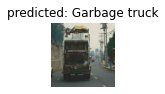

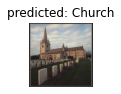

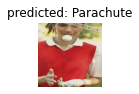

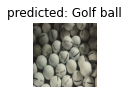

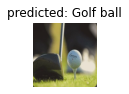

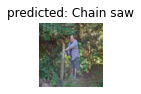

In [36]:
visualize_model(mobilenet_v2)  # all correct

# Comparing with official model

**official model works on 1000 classes, so I think my model's criterion will be better than it**

In [35]:
# 下载官方模型
official_model = models.mobilenet_v2(pretrained=True).to(device)
# 加载自己的模型
my_model = models.mobilenet_v2(pretrained=False, num_classes=10).to(device)
my_model.load_state_dict(torch.load("./imagenette_best_state"))

<All keys matched successfully>

## For discovering official model's label about our test dataset,I need do preparations

In [56]:
def find_official_model_labels(model):
    model.eval()
    index = 0
    pre_dict = {
        'Tench': {},
        'English springer': {},
        'Cassette player': {},
        'Chain saw': {},
        'Church': {},
        'French horn': {},
        'Garbage truck': {},
        'Gas pump': {},
        'Golf ball': {},
        'Parachute': {},
    }
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                index += 1
                real_label = Imagenette_320_Dataset.map_to_name(int(labels.data[j]))
                pre_num = int(preds[j])
                print(f'Predicted num: {pre_num}, Real label: {real_label}')
                p = pre_dict[real_label]
                if pre_num in p.keys():
                    numbers = p[pre_num] + 1
                else:
                    numbers = 1
                pre_dict[real_label].update({pre_num: numbers})

    return pre_dict

In [60]:
# first we should use dataset to find mapping in official model
official_model_labels = find_official_model_labels(official_model)
print(official_model_labels)
# extract label datas
print("--------------------- start extract label mapping")
official_label_mapping = {}
for i in official_model_labels:
    max_num = -1
    max = 0
    for key in official_model_labels[i]:
        if max < official_model_labels[i][key]:
            max = official_model_labels[i][key]
            max_num = key
    official_label_mapping.update({max_num: i})

print(f"Official_label_mapping: {official_label_mapping}")

Predicted num: 569, Real label: Garbage truck
Predicted num: 80, Real label: English springer
Predicted num: 996, Real label: Gas pump
Predicted num: 701, Real label: Parachute
Predicted num: 217, Real label: English springer
Predicted num: 217, Real label: English springer
Predicted num: 571, Real label: Gas pump
Predicted num: 491, Real label: Chain saw
Predicted num: 569, Real label: Garbage truck
Predicted num: 217, Real label: English springer
Predicted num: 701, Real label: Parachute
Predicted num: 571, Real label: Gas pump
Predicted num: 566, Real label: French horn
Predicted num: 574, Real label: Golf ball
Predicted num: 217, Real label: English springer
Predicted num: 217, Real label: English springer
Predicted num: 0, Real label: Tench
Predicted num: 566, Real label: French horn
Predicted num: 116, Real label: Golf ball
Predicted num: 754, Real label: Cassette player
Predicted num: 497, Real label: Church
Predicted num: 482, Real label: Cassette player
Predicted num: 701, Rea

In [74]:
# map to our label
official_label_index = {
    0:0,
    1:217,
    2:482,
    3:491,
    4:497,
    5:566,
    6:569,
    7:571,
    8:574,
    9:701
}
def trans_tensor_to_numpy(tensor:torch.Tensor):
    res = []
    for i in tensor:
        res.append(int(i))
    return res
# comparator
def comparator(model1: nn.Module, model2: nn.Module, dataset_loader):
    # base setting
    model1.eval()
    model2.eval()
    print("Start comparing!")
    running_corrects_1 = 0
    running_corrects_2 = 1
    with torch.set_grad_enabled(False):
        for imgs, labels in tqdm(dataset_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)
            output1 = model1(imgs)
            output2 = model2(imgs)
            # 提取最高得分所在位置
            _, preds1 = torch.max(output1, 1)
            _, preds2 = torch.max(output2, 1)

            running_corrects_1 += torch.sum(preds1 == labels.data)
            preds_2 = trans_tensor_to_numpy(preds2)
            data_label_2 = trans_tensor_to_numpy(labels.data)
            # trans to target label
            data_label_2 = [official_label_index[item] for item in data_label_2]
            running_corrects_2 += sum(np.array(preds_2) == np.array(data_label_2))

    data_size = len(dataset_loader.dataset)
    return running_corrects_1.double() / data_size, int(running_corrects_2) / data_size

In [75]:
my_acc, official_acc = comparator(my_model, official_model, test_loader)
print(f"My acc:{my_acc * 100}%")
print(f"Official acc:{official_acc * 100}%")

Start comparing!


100%|██████████| 159/159 [00:08<00:00, 19.66it/s]

My acc:81.26232741617356%
Official acc:77.63313609467455%


So it turned out our model is better than official!

# Conclusion

**When I was doing this homework, some mistakes were taken by me, so I do some conclusion!**

1. When we prepare our datasets, some notifications:
    > It's a must for us to resize our datasets and make our pictures be transformed to tensor so that neural network can use them.
    > We also need to do some normalize, in this way we can improve our training efficiency and criterion.
    > And for __getItem__ function, we'd better return labels as type tensor(int)

2. When we use DataLoader to load our datasets, **notification**
    > The most important I think is that we should use shuffle to load our datasets, as I have made a careless blunder about it, so at that time, I got a higher loss above 5 and lower criterion about 10 percent, and after I use shuffle=True, my highest criterion on my val data is 96.99901283316879%.

3. When we start training data, some notifications:
    > We should open the grad when we use train datasets to train model, and close the grad when we validate it on val datasets.
    > We should remember to switch model.train() and model.eval() between train and validate so that some parameters change will be omitted at the appropriate time.
    > Last but not least, only when training we should use loss function to do optimizer, don't use optimizer when test or validate.

4. When we read neural network structure, some notifications:
    > We may not easy to understand what's the model, so we can read some papers about it.
    > Then we can do some research on the implementation code so that we can observe the structure in another dimension.

That's all.
